In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from pandas.core import datetools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics import utils

import warnings

warnings.filterwarnings('ignore')
get_ipython().magic('matplotlib inline')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
print("Train data : ", train.shape)
print("Test  data : ", test.shape)

Train data :  (1460, 81)
Test  data :  (1459, 80)


In [4]:
# train = train.iloc[:,1:] #Id열 제거
train["MSSubClass"] = train["MSSubClass"].astype('str')

In [5]:
# Categoric and Numerical 변수 분리
numerical_features = []
categorical_features = []
for f in train.columns:
    if train.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [6]:
print("Numerical Features Qty :", len(numerical_features),"\n")
print("Numerical Features : ", numerical_features, "\n\n")
print("Categorical Features Qty :", len(categorical_features),"\n")
print("Categorical Features :", categorical_features)

Numerical Features Qty : 37 

Numerical Features :  ['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 


Categorical Features Qty : 44 

Categorical Features : ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC

In [7]:
def detect_outliers(data, feature):
    
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    IQR = Q3 - Q1
        
    outlier_lenth = 1.5 * IQR
        
    outliers = data[(data[feature] < Q1 - outlier_lenth) | (data[feature] > Q3 + outlier_lenth)].index.tolist()

    return outliers

In [8]:
GrLivArea_outliers = detect_outliers(train, "GrLivArea")
print(GrLivArea_outliers)

[58, 118, 185, 197, 231, 304, 324, 496, 523, 583, 608, 635, 691, 769, 798, 803, 961, 1024, 1031, 1046, 1142, 1169, 1173, 1175, 1182, 1268, 1298, 1312, 1328, 1353, 1386]


In [9]:
GarageCars_outliers = detect_outliers(train, "GarageArea")
print(GarageCars_outliers)

[178, 224, 270, 317, 408, 581, 664, 718, 803, 825, 1061, 1087, 1142, 1184, 1190, 1228, 1241, 1268, 1298, 1350, 1417]


In [10]:
OverallQual_outliers = detect_outliers(train, "OverallQual")
print(OverallQual_outliers)

[375, 533]


## Missing Data

In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]
# y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
# all_data.drop(['SalePrice'], axis=1, inplace=True)
print("All data size is {}".format(all_data.shape))

All data size is (2919, 81)


In [12]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [13]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning']= all_data["MSZoning"].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop('Utilities', axis=1)

all_data['Functional']= all_data["Functional"].fillna("Typ")

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
all_data["Electrical"] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data["KitchenQual"]=all_data["KitchenQual"].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

## Correlation

#### 1. numerical features

In [14]:
corrmat = train.corr()
corrmat

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
LotFrontage,-0.010601,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.005968,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


In [15]:
# f, ax = plt.subplots(figsize = (15,9))
# sns.heatmap(corrmat, vmax = 1, square=True)

In [16]:
k = 15

cor_numerical_cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index 
cor_numerical_cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces',
       'BsmtFinSF1'],
      dtype='object')

#### 2. categorical features

In [17]:
train_cat = train[categorical_features]
y_train_d = train['SalePrice']

train_cat = pd.concat([y_train_d, train_cat], axis=1)
train_cat.tail()

,SalePrice,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
1455,175000,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,210000,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,266500,70,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,142125,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1459,147500,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [18]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
categorical_encoded = []
for q in categorical_features:  
    encode(train_cat, q)
    categorical_encoded.append(q+'_E')
print(categorical_encoded)

['MSSubClass_E', 'MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [19]:
corrmat2 = train_cat.corr()
corrmat2

,SalePrice,MSSubClass_E,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,Utilities_E,LotConfig_E,LandSlope_E,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
SalePrice,1.000000,0.476982,0.324610,0.041036,0.534319,0.265699,0.158437,0.014314,0.122882,0.051152,...,0.445598,0.513105,0.156693,0.162827,0.231357,0.595229,0.201953,0.322456,0.366821,0.238111
MSSubClass_E,0.476982,1.000000,0.406206,0.069998,0.278182,0.247816,0.101803,-0.008552,0.102614,-0.016969,...,0.554915,0.476200,0.180696,0.198472,0.307554,0.411606,0.065384,0.168948,0.186336,0.150726
MSZoning_E,0.324610,0.406206,1.000000,0.084606,0.554911,0.187166,0.045657,-0.009400,0.079673,0.006208,...,0.353461,0.263066,0.136268,0.171514,0.289688,NaN,0.011010,0.156708,0.172691,0.121091
Street_E,0.041036,0.069998,0.084606,1.000000,NaN,-0.023314,-0.016663,-0.001682,-0.000463,-0.179360,...,0.049534,0.001227,-0.005985,-0.011457,0.024521,NaN,NaN,0.023447,0.042360,-0.000132
Alley_E,0.534319,0.278182,0.554911,NaN,1.000000,0.173595,-0.012867,NaN,0.014391,0.080200,...,0.171088,0.517607,0.273556,0.271510,0.180399,NaN,0.163663,NaN,0.287164,0.043580
LotShape_E,0.265699,0.247816,0.187166,-0.023314,0.173595,1.000000,0.150626,-0.022853,0.341733,0.155286,...,0.193108,0.213898,0.097004,0.087474,0.103826,-0.315063,0.139455,0.213704,0.042979,0.048021
LandContour_E,0.158437,0.101803,0.045657,-0.016663,-0.012867,0.150626,1.000000,0.002910,0.067484,0.300280,...,0.104570,0.125435,0.051298,0.017307,0.072090,0.420084,-0.038725,-0.020264,0.078428,0.058891
Utilities_E,0.014314,-0.008552,-0.009400,-0.001682,NaN,-0.022853,0.002910,1.000000,-0.074630,0.005909,...,0.003267,-0.006082,-0.002673,-0.005116,-0.007586,NaN,NaN,NaN,0.028270,0.083578
LotConfig_E,0.122882,0.102614,0.079673,-0.000463,0.014391,0.341733,0.067484,-0.074630,1.000000,0.046764,...,0.080011,0.051309,0.004622,-0.016161,0.063821,-0.070014,0.120252,0.109091,-0.026608,-0.040893
LandSlope_E,0.051152,-0.016969,0.006208,-0.179360,0.080200,0.155286,0.300280,0.005909,0.046764,1.000000,...,-0.029106,-0.024092,0.011656,-0.014230,-0.024538,NaN,-0.032868,-0.028987,-0.047691,-0.046610


In [20]:
k = 6

cor_categorical_cols = corrmat2.nlargest(k, 'SalePrice')['SalePrice'].index 
cor_categorical_cols

Index(['SalePrice', 'Neighborhood_E', 'ExterQual_E', 'KitchenQual_E',
       'BsmtQual_E', 'PoolQC_E'],
      dtype='object')

## First OLS
- for detecting outliers & Selecting variables

In [21]:
train = all_data[:ntrain]
test = all_data[ntrain:]

train = sm.add_constant(train)
train.tail()

,const,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,...,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1455,1.0,953,694,0,None,3,1Fam,TA,No,0.0,...,175000.0,WD,0,Pave,7,953.0,0,1999,2000,2007
1456,1.0,2073,0,0,None,3,1Fam,TA,No,790.0,...,210000.0,WD,0,Pave,7,1542.0,349,1978,1988,2010
1457,1.0,1188,1152,0,None,4,1Fam,Gd,No,275.0,...,266500.0,WD,0,Pave,9,1152.0,0,1941,2006,2010
1458,1.0,1078,0,0,None,2,1Fam,TA,Mn,49.0,...,142125.0,WD,0,Pave,5,1078.0,366,1950,1996,2010
1459,1.0,1256,0,0,None,3,1Fam,TA,No,830.0,...,147500.0,WD,0,Pave,6,1256.0,736,1965,1965,2008


### 1. numerical

In [22]:
train_n = train[numerical_features]
train_n = train_n.drop(['Id', 'SalePrice'], axis=1)
y_train_l = np.log1p(y_train_d)

In [23]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_n.values, i) for i in range(train_n.values.shape[1])]
vif["features"] = train_n.columns
vif

#높으면 빼도 되는 것

,VIF Factor,features
0,1.587011e+01,LotFrontage
1,2.669097e+00,LotArea
2,6.595937e+01,OverallQual
3,4.141501e+01,OverallCond
4,1.736752e+04,YearBuilt
5,2.109914e+04,YearRemodAdd
6,1.853062e+00,MasVnrArea
7,inf,BsmtFinSF1
8,inf,BsmtFinSF2
9,inf,BsmtUnfSF


In [24]:
model1_1 = sm.OLS(y_train_l, train_n)
result1_1 = model1_1.fit()
print(result1_1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.904e+05
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:57:11   Log-Likelihood:                 729.70
No. Observations:                1460   AIC:                            -1393.
Df Residuals:                    1427   BIC:                            -1219.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
LotFrontage       0.0002      0.000      1.105

### 2. categorical(dummies)

In [25]:
#utilities none값에서 삭제 했음
categorical_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

train_c = pd.get_dummies(train[categorical_features])
train_c.tail()

,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1455,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1456,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1458,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1459,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [26]:
model1_2 = sm.OLS(y_train_l, train_c)
result1_2 = model1_2.fit()
print(result1_2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     40.69
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:57:12   Log-Likelihood:                 837.36
No. Observations:                1460   AIC:                            -1215.
Df Residuals:                    1230   BIC:                             1.107
Df Model:                         229                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MSSubClass_120            0.02

### 3. numerical + categorical(dummies)

In [27]:
train_all = pd.concat([train_n, train_c], axis=1)
train_all.tail()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1455,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,953.0,...,0,0,0,1,0,0,0,0,1,0
1456,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,589.0,...,0,0,0,1,0,0,0,0,1,0
1457,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,877.0,...,0,0,0,1,0,0,0,0,1,0
1458,68.0,9717,5,6,1950,1996,0.0,49.0,1029.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1459,75.0,9937,5,6,1965,1965,0.0,830.0,290.0,136.0,...,0,0,0,1,0,0,0,0,1,0


In [28]:
model1_3 = sm.OLS(y_train_l, train_all)
result1_3 = model1_3.fit()
print(result1_3.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     78.83
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:57:12   Log-Likelihood:                 1388.8
No. Observations:                1460   AIC:                            -2252.
Df Residuals:                    1197   BIC:                            -861.4
Df Model:                         262                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotFrontage               0.00

### 4. numerical(correlation top 15)

In [29]:
cor_numerical_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces',
       'BsmtFinSF1']

train_nc = train[cor_numerical_cols]
train_nc.tail()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1
1455,6,1647,2.0,460.0,953.0,953,2,7,1999,2000,1999.0,0.0,1,0.0
1456,6,2073,2.0,500.0,1542.0,2073,2,7,1978,1988,1978.0,119.0,2,790.0
1457,7,2340,1.0,252.0,1152.0,1188,2,9,1941,2006,1941.0,0.0,2,275.0
1458,5,1078,1.0,240.0,1078.0,1078,1,5,1950,1996,1950.0,0.0,0,49.0
1459,5,1256,1.0,276.0,1256.0,1256,1,6,1965,1965,1965.0,0.0,0,830.0


In [30]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_nc.values, i) for i in range(train_nc.values.shape[1])]
vif["features"] = train_nc.columns
vif

,VIF Factor,features
0,50.035360,OverallQual
1,49.991815,GrLivArea
2,37.539832,GarageCars
3,30.282152,GarageArea
4,26.336377,TotalBsmtSF
5,37.845152,1stFlrSF
6,18.854813,FullBath
7,58.229351,TotRmsAbvGrd
8,8521.324441,YearBuilt
9,8366.771684,YearRemodAdd


In [31]:
model1_4 = sm.OLS(y_train_l, train_nc)
result1_4 = model1_4.fit()
print(result1_4.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.691e+05
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:57:12   Log-Likelihood:                 585.20
No. Observations:                1460   AIC:                            -1142.
Df Residuals:                    1446   BIC:                            -1068.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
OverallQual      0.0816      0.005     16.938   

### 5. numerical + categorical(correlation top 15,5)

In [32]:
cor_categorical_cols = ['Neighborhood', 'ExterQual', 'KitchenQual',
       'BsmtQual', 'PoolQC']

train_cc = train[cor_categorical_cols]
train_cc.tail()

train_all_c = pd.concat([train_nc, train_cc], axis=1)
train_all_c.tail()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,Neighborhood,ExterQual,KitchenQual,BsmtQual,PoolQC
1455,6,1647,2.0,460.0,953.0,953,2,7,1999,2000,1999.0,0.0,1,0.0,Gilbert,TA,TA,Gd,None
1456,6,2073,2.0,500.0,1542.0,2073,2,7,1978,1988,1978.0,119.0,2,790.0,NWAmes,TA,TA,Gd,None
1457,7,2340,1.0,252.0,1152.0,1188,2,9,1941,2006,1941.0,0.0,2,275.0,Crawfor,Ex,Gd,TA,None
1458,5,1078,1.0,240.0,1078.0,1078,1,5,1950,1996,1950.0,0.0,0,49.0,NAmes,TA,Gd,TA,None
1459,5,1256,1.0,276.0,1256.0,1256,1,6,1965,1965,1965.0,0.0,0,830.0,Edwards,Gd,TA,TA,None


In [33]:
train_all_c = sm.add_constant(train_all_c)
train_all_c = pd.get_dummies(train_all_c)

train_all_c.tail()

,const,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,KitchenQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None
1455,1.0,6,1647,2.0,460.0,953.0,953,2,7,1999,...,1,0,0,1,0,0,0,0,0,1
1456,1.0,6,2073,2.0,500.0,1542.0,2073,2,7,1978,...,1,0,0,1,0,0,0,0,0,1
1457,1.0,7,2340,1.0,252.0,1152.0,1188,2,9,1941,...,0,0,0,0,0,1,0,0,0,1
1458,1.0,5,1078,1.0,240.0,1078.0,1078,1,5,1950,...,0,0,0,0,0,1,0,0,0,1
1459,1.0,5,1256,1.0,276.0,1256.0,1256,1,6,1965,...,1,0,0,0,0,1,0,0,0,1


In [34]:
model1_5 = sm.OLS(y_train_l, train_all_c)
result1_5 = model1_5.fit()
print(result1_5.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     187.5
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:57:12   Log-Likelihood:                 767.38
No. Observations:                1460   AIC:                            -1431.
Df Residuals:                    1408   BIC:                            -1156.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.5106 

In [35]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_all_c.values, i) for i in range(train_all_c.values.shape[1])]
vif["features"] = train_all_c.columns
vif

,VIF Factor,features
0,0.000000,const
1,3.923020,OverallQual
2,6.713399,GrLivArea
3,6.552045,GarageCars
4,5.732055,GarageArea
5,6.989393,TotalBsmtSF
6,6.077954,1stFlrSF
7,2.641831,FullBath
8,3.883378,TotRmsAbvGrd
9,6.738343,YearBuilt


In [36]:
model_cat = sm.OLS.from_formula("SalePrice ~ C(Neighborhood)", data=train)
sm.stats.anova_lm(model_cat.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(Neighborhood),24.0,5.023606e+12,2.093169e+11,71.784865,1.558600e-225
Residual,1435.0,4.184305e+12,2.915892e+09,NaN,NaN


In [37]:
model_cat = sm.OLS.from_formula("SalePrice ~ C(ExterQual)", data=train)
sm.stats.anova_lm(model_cat.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(ExterQual),3.0,4.395744e+12,1.465248e+12,443.334831,1.439551e-204
Residual,1456.0,4.812167e+12,3.305060e+09,NaN,NaN


In [38]:
model_cat = sm.OLS.from_formula("SalePrice ~ C(KitchenQual)", data=train)
sm.stats.anova_lm(model_cat.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(KitchenQual),3.0,4.204320e+12,1.401440e+12,407.806352,3.032213e-192
Residual,1456.0,5.003592e+12,3.436533e+09,NaN,NaN


In [39]:
model_cat = sm.OLS.from_formula("SalePrice ~ C(BsmtQual)", data=train)
sm.stats.anova_lm(model_cat.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(BsmtQual),4.0,4.281621e+12,1.070405e+12,316.148635,8.158548e-196
Residual,1455.0,4.926290e+12,3.385766e+09,NaN,NaN


In [40]:
model_cat = sm.OLS.from_formula("SalePrice ~ C(PoolQC)", data=train)
sm.stats.anova_lm(model_cat.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(PoolQC),3.0,1.951702e+11,6.505672e+10,10.509853,7.700989e-07
Residual,1456.0,9.012741e+12,6.190069e+09,NaN,NaN


#### 성능 비교

In [41]:
# adj r^2
print(result1_1.rsquared_adj)
print(result1_2.rsquared_adj)
print(result1_3.rsquared_adj)
print(result1_4.rsquared_adj)
print(result1_5.rsquared_adj)

0.9998476791817901
0.8616798648653539
0.9332264620894861
0.9998167761418959
0.867010499542905


In [42]:
#AIC
print(result1_1.aic)
print(result1_2.aic)
print(result1_3.aic)
print(result1_4.aic)
print(result1_5.aic)

-1393.3948796096452
-1214.7173163945513
-2251.688475707486
-1142.3929660338258
-1430.7683576721279


In [43]:
#BIC
print(result1_1.bic)
print(result1_2.bic)
print(result1_3.bic)
print(result1_4.bic)
print(result1_5.bic)

-1218.9505530244664
1.1067779869965761
-861.4200547407593
-1068.3862820279924
-1155.886388507604


- adj r^2 : 모델 1, 4 거의 비슷
- AIC : 모델 1, 5 거의 비슷
- BIC : 모델 1, 5 거의 비슷

#### partial regression plot & CCPR

In [44]:
# fig = plt.figure(figsize=(8,30))
# sm.graphics.plot_partregress_grid(result1_1, fig=fig)
# fig.suptitle("")
# plt.show

In [45]:
# fig = plt.figure(figsize=(15,40))
# sm.graphics.plot_ccpr_grid(result1_1, fig=fig)
# fig.suptitle("")
# plt.show

## Outliers

In [46]:
influence = result1_1.get_influence()
# hat = influence.hat_matrix_diag

# plt.figure(figsize=(15,6))
# plt.stem(hat)
# plt.show()

In [47]:
# hat.sum()

In [48]:
# plt.figure(figsize=(15, 6))
# plt.stem(result1_1.resid_pearson)
# plt.show()

In [49]:
# g = sm.graphics.plot_leverage_resid2(result1_1)
# g.set_size_inches(15,5)
# plt.show()

In [50]:
o_train = train[result1_1.resid_pearson > 2]
print(len(o_train))
idx_r = np.where(result1_1.resid_pearson > 2)[0]
print(idx_r)

26
[  48  142  151  178  181  218  277  378  457  473  546  669  681  688
  803  807  898  970 1046 1059 1065 1075 1170 1181 1182 1423]


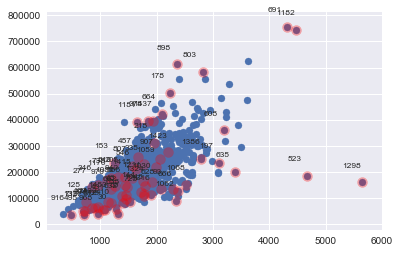

67 [  30   48   88   93  125  144  153  178  197  205  218  277  335  346
  375  378  410  431  457  462  495  523  546  588  608  628  632  635
  658  662  664  666  691  705  710  728  738  803  807  810  812  898
  907  916  942  968  970 1030 1048 1059 1062 1068 1080 1170 1181 1182
 1211 1216 1298 1324 1337 1386 1415 1423 1432 1437 1453]


In [51]:
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(y_train_l) - len(train_n.columns) - 1)
idx_c = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(train['GrLivArea'], y_train_d)
plt.scatter(train['GrLivArea'][idx_c], y_train_d[idx_c], s=100, c="r", alpha=0.3)
utils.annotate_axes(range(len(idx_c)), idx_c, 
                    list(zip(train['GrLivArea'][idx_c], y_train_d[idx_c])), [(-20, 15)] * len(idx_c), size="small", ax=ax)
plt.show()

print(len(idx_c),idx_c)

In [52]:
resid_outliers = idx_r.tolist()
cooks_outliers = idx_c.tolist()
print("resid_outliers:", len(resid_outliers), resid_outliers)
print("\t")
print("cooks_outliers:", len(cooks_outliers), cooks_outliers)
print("\t")
print("(IQR)GrLivArea_outliers:", len(GrLivArea_outliers), GrLivArea_outliers)
print("\t")
print("(IQR)OverallQual_outliers", len(OverallQual_outliers), OverallQual_outliers)
print("\t")
print("(IQR)GarageCars_outliers:", len(GarageCars_outliers), GarageCars_outliers)

#제거하길 추천한 outliers(data description)
recommended_outliers = [523, 898, 1298]

resid_outliers: 26 [48, 142, 151, 178, 181, 218, 277, 378, 457, 473, 546, 669, 681, 688, 803, 807, 898, 970, 1046, 1059, 1065, 1075, 1170, 1181, 1182, 1423]
	
cooks_outliers: 67 [30, 48, 88, 93, 125, 144, 153, 178, 197, 205, 218, 277, 335, 346, 375, 378, 410, 431, 457, 462, 495, 523, 546, 588, 608, 628, 632, 635, 658, 662, 664, 666, 691, 705, 710, 728, 738, 803, 807, 810, 812, 898, 907, 916, 942, 968, 970, 1030, 1048, 1059, 1062, 1068, 1080, 1170, 1181, 1182, 1211, 1216, 1298, 1324, 1337, 1386, 1415, 1423, 1432, 1437, 1453]
	
(IQR)GrLivArea_outliers: 31 [58, 118, 185, 197, 231, 304, 324, 496, 523, 583, 608, 635, 691, 769, 798, 803, 961, 1024, 1031, 1046, 1142, 1169, 1173, 1175, 1182, 1268, 1298, 1312, 1328, 1353, 1386]
	
(IQR)OverallQual_outliers 2 [375, 533]
	
(IQR)GarageCars_outliers: 21 [178, 224, 270, 317, 408, 581, 664, 718, 803, 825, 1061, 1087, 1142, 1184, 1190, 1228, 1241, 1268, 1298, 1350, 1417]


In [53]:
IQR = list(set(GrLivArea_outliers) | set(OverallQual_outliers) | set(GarageCars_outliers))
print(IQR)

[1024, 769, 1031, 1417, 523, 270, 1169, 1298, 1173, 1046, 1175, 533, 664, 408, 798, 1182, 1312, 1184, 803, 1061, 1190, 304, 1328, 178, 691, 185, 58, 825, 317, 1087, 961, 324, 197, 581, 583, 1350, 1353, 1228, 718, 1241, 608, 224, 231, 1386, 496, 1268, 118, 375, 1142, 635]


In [54]:
resid_cooks = list(set(resid_outliers) | set(cooks_outliers))
print(resid_cooks)

[1030, 523, 1298, 277, 1046, 1048, 30, 546, 803, 1059, 1062, 807, 1065, 810, 812, 1068, 1324, 48, 1075, 1080, 1337, 588, 335, 88, 346, 93, 608, 1386, 628, 375, 632, 378, 635, 125, 898, 1415, 907, 142, 1423, 144, 1170, 658, 916, 662, 151, 664, 153, 410, 666, 1432, 669, 1181, 1182, 1437, 681, 1453, 942, 431, 688, 178, 691, 181, 1211, 1216, 705, 197, 710, 968, 457, 970, 205, 462, 728, 473, 218, 738, 495]


In [55]:
IQR2 = list(set(GrLivArea_outliers) & set(GarageCars_outliers))
print(IQR2)

[1298, 803, 1268, 1142]


In [56]:
resid_cooks_IQR = list(set(resid_cooks) | set(IQR))
print(resid_cooks_IQR)

[1024, 769, 1030, 1031, 523, 270, 1298, 277, 1046, 533, 1048, 1175, 30, 798, 1312, 546, 803, 1059, 1061, 1062, 807, 1065, 810, 812, 1068, 1324, 48, 304, 1328, 1075, 1080, 1337, 58, 825, 317, 1087, 324, 581, 1350, 583, 1353, 588, 335, 88, 346, 93, 608, 1386, 628, 118, 375, 632, 1142, 378, 635, 125, 898, 1415, 1417, 907, 142, 1423, 144, 1169, 1170, 658, 916, 1173, 662, 151, 664, 153, 410, 666, 1432, 669, 1181, 1182, 1437, 408, 1184, 1190, 681, 1453, 942, 431, 688, 178, 691, 181, 185, 1211, 1216, 705, 961, 197, 710, 968, 457, 970, 1228, 205, 462, 718, 728, 473, 218, 1241, 224, 738, 231, 495, 496, 1268]


## Select Variables

In [57]:
idx_t = np.where(result1_1.pvalues < 0.05)[0]
print(len(idx_t), idx_t)
tvalues = idx_t.tolist()

20 [ 1  2  3  4  5  7 10 11 14 15 17 20 21 22 24 26 28 30 31 34]


In [58]:
x_train_cols = train_n.columns.tolist()
print(len(x_train_cols))

select = []

for i in tvalues:
    select.append(x_train_cols[i])

print(len(select), select)

35
20 ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'YrSold']


In [59]:
idx_t2 = np.where(result1_3.pvalues < 0.005)[0]
print(len(idx_t2), idx_t2)
tvalues2 = idx_t2.tolist()

x_train_cols2 = train_all.columns.tolist()
print(len(x_train_cols2))

select_c = []

for i in tvalues2:
    select_c.append(x_train_cols2[i])

print(len(select_c), select_c)

select_c = ['MSZoning', 'Neighborhood', 'Condition2', 'RoofMatl', 'Functional']

40 [  1   2   3   4   5   7  10  14  25  26  30  51  52  53  82  92  98 111
 112 113 114 117 124 136 137 138 139 140 142 143 144 148 226 246 248 249
 252 270 280 302]
314
40 ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'Neighborhood_Crawfor', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRNn', 'HouseStyle_1.5Unf', 'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'Heating_GasW', 'Functional_Maj1', 'Functional_Min1', 'Functional_Min2', 'Functional_Typ', 'GarageQual_Ex', 'GarageCond_Po', 'SaleType_ConLD']


In [60]:
x_train_new = train_n[select]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_train_new.values, i) for i in range(x_train_new.values.shape[1])]
vif["features"] = x_train_new.columns
vif.sort_values(by="VIF Factor", ascending=True)

,VIF Factor,features
18,1.070626,PoolArea
17,1.170613,ScreenPorch
16,1.426199,EnclosedPorch
15,1.851504,WoodDeckSF
0,2.524493,LotArea
13,2.867944,Fireplaces
9,3.079493,BsmtFullBath
5,4.488814,BsmtFinSF1
14,12.509448,GarageCars
10,21.737438,FullBath


- Yearsold, YearRemodAdd, TotRmsAbvGrd, OverallQual 제외

- ** OverrallCond, 1stFlrSF, KitchenAbvGr, PoolArea, Screenporch(from_formula 사용시)

In [61]:
select = ['LotArea', 'OverallCond', 'YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea']
print(len(select), select)

x_train_new = x_train_new[select]

16 ['LotArea', 'OverallCond', 'YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea']


- 참고 : 상관계수와 coef?

In [62]:
print(len(cor_numerical_cols),cor_numerical_cols)
print("\t")

cols_common = set(select) & set(cor_numerical_cols)
cols_sum = set(select) | set(cor_numerical_cols)

print(len(cols_common), cols_common)
print("\t")
print(len(cols_sum), cols_sum)

14 ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1']
	
8 {'FullBath', '1stFlrSF', 'TotalBsmtSF', 'GarageCars', 'Fireplaces', 'GrLivArea', 'YearBuilt', 'BsmtFinSF1'}
	
22 {'FullBath', '1stFlrSF', 'WoodDeckSF', 'TotalBsmtSF', 'ScreenPorch', 'GarageCars', 'Fireplaces', 'MasVnrArea', 'PoolArea', 'YearBuilt', 'TotRmsAbvGrd', 'LotArea', 'OverallCond', 'GarageArea', 'OverallQual', 'GarageYrBlt', 'YearRemodAdd', 'GrLivArea', 'BsmtFullBath', 'EnclosedPorch', 'KitchenAbvGr', 'BsmtFinSF1'}


In [63]:
select = ['EnclosedPorch', '1stFlrSF', 'BsmtFinSF1', 'GarageCars', 'YearRemodAdd', 'BsmtFullBath', 'MasVnrArea', 'Fireplaces', 'TotalBsmtSF', 'PoolArea', 'OverallCond', 'ScreenPorch', 'WoodDeckSF', 'LotArea', 'YearBuilt', 'GarageArea', 'GrLivArea', 'KitchenAbvGr', 'TotRmsAbvGrd', 'FullBath', 'GarageYrBlt', 'OverallQual']
len(select)

22

In [64]:
select_VIF = ['MasVnrArea', 'EnclosedPorch', 'BsmtFinSF1', 'GarageCars', 'BsmtFullBath', 'Fireplaces', 'TotalBsmtSF', 'ScreenPorch', 'WoodDeckSF', 'LotArea', 'YearBuilt', 'GrLivArea', 'KitchenAbvGr', 'FullBath', 'OverallQual', 'OverallCond']

In [65]:
x_train_new = train_n[select_VIF]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_train_new.values, i) for i in range(x_train_new.values.shape[1])]
vif["features"] = x_train_new.columns
vif.sort_values(by="VIF Factor", ascending=True)

,VIF Factor,features
7,1.155940,ScreenPorch
1,1.225614,EnclosedPorch
0,1.769256,MasVnrArea
8,1.838235,WoodDeckSF
9,2.498450,LotArea
5,2.770257,Fireplaces
4,3.054476,BsmtFullBath
2,4.407584,BsmtFinSF1
3,11.641829,GarageCars
6,13.632549,TotalBsmtSF


## Second OLS

In [66]:
train_cc = train[cor_categorical_cols]

In [67]:
#추가 작업
train_cc = train_cc.drop(['PoolQC'], axis=1)

train_cc = train_cc.drop(resid_cooks)
train_n = train_n[select_VIF]
train_n = train_n.drop(resid_cooks)
#추가 작업-변수 변환 
train_n = np.log1p(train_n)
x_train_new = train_n
x_train_new = pd.concat([train_n, train_cc], axis=1)
#add constatns
# x_train_new = sm.add_constant(x_train_new)

y_train_new = y_train_d.drop(resid_cooks)
y_train_new = np.log1p(y_train_new)

# #from_formula 사용 위해
train_new = pd.concat([y_train_new, x_train_new], axis=1)
train_new.tail()

,SalePrice,MasVnrArea,EnclosedPorch,BsmtFinSF1,GarageCars,BsmtFullBath,Fireplaces,TotalBsmtSF,ScreenPorch,WoodDeckSF,...,YearBuilt,GrLivArea,KitchenAbvGr,FullBath,OverallQual,OverallCond,Neighborhood,ExterQual,KitchenQual,BsmtQual
1455,12.072547,0.000000,0.000000,0.000000,1.098612,0.000000,0.693147,6.860664,0.0,0.000000,...,7.600902,7.407318,0.693147,1.098612,1.945910,1.791759,Gilbert,TA,TA,Gd
1456,12.254868,4.787492,0.000000,6.673298,1.098612,0.693147,1.098612,7.341484,0.0,5.857933,...,7.590347,7.637234,0.693147,1.098612,1.945910,1.945910,NWAmes,TA,TA,Gd
1457,12.493133,0.000000,0.000000,5.620401,0.693147,0.000000,1.098612,7.050123,0.0,0.000000,...,7.571474,7.758333,0.693147,1.098612,2.079442,2.302585,Crawfor,Ex,Gd,TA
1458,11.864469,0.000000,4.727388,3.912023,0.693147,0.693147,0.000000,6.983790,0.0,5.905362,...,7.576097,6.983790,0.693147,0.693147,1.791759,1.945910,NAmes,TA,Gd,TA
1459,11.901590,0.000000,0.000000,6.722630,0.693147,0.693147,0.000000,7.136483,0.0,6.602588,...,7.583756,7.136483,0.693147,0.693147,1.791759,1.945910,Edwards,Gd,TA,TA


In [68]:
select_scale = []

for num in select_VIF:
    x = "scale(" + num + ")"
    select_scale.append(x)

print(select_scale)

formula = " + ".join(select_scale)
formula

['scale(MasVnrArea)', 'scale(EnclosedPorch)', 'scale(BsmtFinSF1)', 'scale(GarageCars)', 'scale(BsmtFullBath)', 'scale(Fireplaces)', 'scale(TotalBsmtSF)', 'scale(ScreenPorch)', 'scale(WoodDeckSF)', 'scale(LotArea)', 'scale(YearBuilt)', 'scale(GrLivArea)', 'scale(KitchenAbvGr)', 'scale(FullBath)', 'scale(OverallQual)', 'scale(OverallCond)']


'scale(MasVnrArea) + scale(EnclosedPorch) + scale(BsmtFinSF1) + scale(GarageCars) + scale(BsmtFullBath) + scale(Fireplaces) + scale(TotalBsmtSF) + scale(ScreenPorch) + scale(WoodDeckSF) + scale(LotArea) + scale(YearBuilt) + scale(GrLivArea) + scale(KitchenAbvGr) + scale(FullBath) + scale(OverallQual) + scale(OverallCond)'

In [69]:
train_cc.columns

Index(['Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual'], dtype='object')

In [70]:
train_new.tail()

,SalePrice,MasVnrArea,EnclosedPorch,BsmtFinSF1,GarageCars,BsmtFullBath,Fireplaces,TotalBsmtSF,ScreenPorch,WoodDeckSF,...,YearBuilt,GrLivArea,KitchenAbvGr,FullBath,OverallQual,OverallCond,Neighborhood,ExterQual,KitchenQual,BsmtQual
1455,12.072547,0.000000,0.000000,0.000000,1.098612,0.000000,0.693147,6.860664,0.0,0.000000,...,7.600902,7.407318,0.693147,1.098612,1.945910,1.791759,Gilbert,TA,TA,Gd
1456,12.254868,4.787492,0.000000,6.673298,1.098612,0.693147,1.098612,7.341484,0.0,5.857933,...,7.590347,7.637234,0.693147,1.098612,1.945910,1.945910,NWAmes,TA,TA,Gd
1457,12.493133,0.000000,0.000000,5.620401,0.693147,0.000000,1.098612,7.050123,0.0,0.000000,...,7.571474,7.758333,0.693147,1.098612,2.079442,2.302585,Crawfor,Ex,Gd,TA
1458,11.864469,0.000000,4.727388,3.912023,0.693147,0.693147,0.000000,6.983790,0.0,5.905362,...,7.576097,6.983790,0.693147,0.693147,1.791759,1.945910,NAmes,TA,Gd,TA
1459,11.901590,0.000000,0.000000,6.722630,0.693147,0.693147,0.000000,7.136483,0.0,6.602588,...,7.583756,7.136483,0.693147,0.693147,1.791759,1.945910,Edwards,Gd,TA,TA


In [71]:
# train_new = train_new.drop(['1stFlrSF'], axis=1)
train_new.tail()

,SalePrice,MasVnrArea,EnclosedPorch,BsmtFinSF1,GarageCars,BsmtFullBath,Fireplaces,TotalBsmtSF,ScreenPorch,WoodDeckSF,...,YearBuilt,GrLivArea,KitchenAbvGr,FullBath,OverallQual,OverallCond,Neighborhood,ExterQual,KitchenQual,BsmtQual
1455,12.072547,0.000000,0.000000,0.000000,1.098612,0.000000,0.693147,6.860664,0.0,0.000000,...,7.600902,7.407318,0.693147,1.098612,1.945910,1.791759,Gilbert,TA,TA,Gd
1456,12.254868,4.787492,0.000000,6.673298,1.098612,0.693147,1.098612,7.341484,0.0,5.857933,...,7.590347,7.637234,0.693147,1.098612,1.945910,1.945910,NWAmes,TA,TA,Gd
1457,12.493133,0.000000,0.000000,5.620401,0.693147,0.000000,1.098612,7.050123,0.0,0.000000,...,7.571474,7.758333,0.693147,1.098612,2.079442,2.302585,Crawfor,Ex,Gd,TA
1458,11.864469,0.000000,4.727388,3.912023,0.693147,0.693147,0.000000,6.983790,0.0,5.905362,...,7.576097,6.983790,0.693147,0.693147,1.791759,1.945910,NAmes,TA,Gd,TA
1459,11.901590,0.000000,0.000000,6.722630,0.693147,0.693147,0.000000,7.136483,0.0,6.602588,...,7.583756,7.136483,0.693147,0.693147,1.791759,1.945910,Edwards,Gd,TA,TA


In [72]:
# x_train_new = pd.get_dummies(x_train_new)
# x_train_new.tail()

In [74]:
model2_1 = sm.OLS.from_formula("SalePrice ~ scale(MasVnrArea) + scale(EnclosedPorch) + scale(BsmtFinSF1) + scale(GarageCars) + scale(BsmtFullBath) + scale(Fireplaces) + scale(TotalBsmtSF) + scale(ScreenPorch) + scale(WoodDeckSF) + scale(LotArea) + scale(YearBuilt) + scale(GrLivArea) + scale(KitchenAbvGr) + scale(FullBath) + scale(OverallQual) + scale(OverallCond) + C(Neighborhood) + C(ExterQual) + C(KitchenQual) + C(BsmtQual)", data=train_new)
result2_1 = model2_1.fit()
print(result2_1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     440.3
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:57:31   Log-Likelihood:                 1384.8
No. Observations:                1383   AIC:                            -2668.
Df Residuals:                    1332   BIC:                            -2401.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

- ANOVA

In [ ]:
# #모형비교

# model_full = sm.OLS.from_formula("SalePrice ~ scale(EnclosedPorch) + scale(BsmtFinSF1) + scale(OverallCond) + scale(GarageCars) + scale(BsmtFullBath) + scale(MasVnrArea) + scale(Fireplaces) + scale(TotalBsmtSF) + scale(ScreenPorch) + scale(WoodDeckSF) + scale(LotArea) + scale(YearBuilt) + scale(GrLivArea) + scale(KitchenAbvGr) + scale(FullBath) + scale(OverallQual) + C(Neighborhood) + C(ExterQual) + C(KitchenQual) + C(BsmtQual)", data=train_new)
# model_reduced = sm.OLS.from_formula("SalePrice ~ scale(EnclosedPorch) + scale(BsmtFinSF1) + scale(OverallCond) + scale(GarageCars) + scale(BsmtFullBath) + scale(MasVnrArea) + scale(Fireplaces) + scale(TotalBsmtSF) + scale(ScreenPorch) + scale(WoodDeckSF) + scale(LotArea) + scale(YearBuilt) + scale(GrLivArea) + scale(KitchenAbvGr) + scale(FullBath) + scale(OverallQual) + C(Neighborhood) + C(ExterQual) + C(KitchenQual) + C(BsmtQual)", data=train_new)

# sm.stats.anova_lm(model_reduced.fit(), model_full.fit())

In [75]:
#변수비교
sm.stats.anova_lm(result2_1, typ=2)

,sum_sq,df,F,PR(>F)
C(Neighborhood),1.875179,24.0,9.521226,3.712895e-32
C(ExterQual),0.053279,3.0,2.164201,9.048405e-02
C(KitchenQual),0.392355,3.0,15.937467,3.489500e-10
C(BsmtQual),1.280837,4.0,39.020719,6.317242e-31
scale(MasVnrArea),0.000827,1.0,0.100719,7.510178e-01
scale(EnclosedPorch),0.016727,1.0,2.038315,1.536139e-01
scale(BsmtFinSF1),0.252062,1.0,30.716248,3.595813e-08
scale(GarageCars),0.633782,1.0,77.232771,4.592676e-18
scale(BsmtFullBath),0.297954,1.0,36.308752,2.176085e-09
scale(Fireplaces),0.268543,1.0,32.724629,1.309629e-08


In [ ]:
# result2_2 = model2_1.fit_regularized(alpha=0.01, L1_wt=1)
# print(result2_2.params)

- RMSE

In [76]:
train_new2 = train_new.drop(['SalePrice'], axis=1)

y_train_new2 = result2_1.predict(train_new2)
y_train_new2 = np.exp(y_train_new2)
y_train_new2 = np.array(y_train_new2)
print(y_train_new2)

[204829.17859765 199593.10347479 221994.79505875 ... 258012.68614283
 134438.09239281 146397.19460761]


In [77]:
y_train_new = np.array(y_train_new)
y_train_new = np.exp(y_train_new)
print(y_train_new)

[208501. 181501. 223501. ... 266501. 142126. 147501.]


In [78]:
sm.tools.eval_measures.rmse(y_train_new, y_train_new2, axis=0)

17670.62001025187

- 잔차 정규성

In [79]:
test_norm = sms.omni_normtest(result2_1.resid)
for xi in zip(['Chi^2', 'P-value'], test_norm):
    print("%-12s: %6.3f" % xi)

Chi^2       : 65.640
P-value     :  0.000


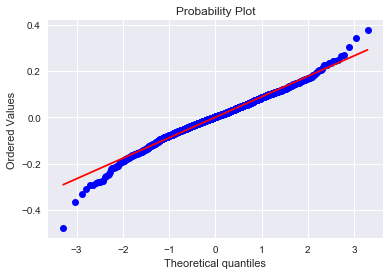

In [80]:
sp.stats.probplot(result2_1.resid, plot=plt)
plt.show()

In [81]:
# select_new = ['EnclosedPorch', '1stFlrSF', 'BsmtFinSF1', 'GarageCars', 'YearRemodAdd', 'BsmtFullBath', 'MasVnrArea', 'Fireplaces', 'TotalBsmtSF', 'PoolArea', 'OverallCond', 'ScreenPorch', 'WoodDeckSF', 'LotArea', 'YearBuilt', 'GarageArea', 'GrLivArea', 'KitchenAbvGr', 'TotRmsAbvGrd', 'FullBath', 'GarageYrBlt', 'OverallQual'] 
select_new2 = ['Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual']

In [82]:
test_new = test[select_VIF]
test_new = np.log1p(test_new)

# test_new = test_new.drop(['1stFlrSF'], axis=1)

test_new2 = test[select_new2]

test_new = pd.concat([test_new, test_new2], axis=1)
test_new.tail()
# test_new = pd.get_dummies(test_new)

# test_new = sm.add_constant(test_new)

,MasVnrArea,EnclosedPorch,BsmtFinSF1,GarageCars,BsmtFullBath,Fireplaces,TotalBsmtSF,ScreenPorch,WoodDeckSF,LotArea,YearBuilt,GrLivArea,KitchenAbvGr,FullBath,OverallQual,OverallCond,Neighborhood,ExterQual,KitchenQual,BsmtQual
2914,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,6.304449,0.0,0.000000,7.568896,7.586296,6.996681,0.693147,0.693147,1.609438,2.079442,MeadowV,TA,TA,TA
2915,0.000000,0.0,5.533389,0.693147,0.000000,0.000000,6.304449,0.0,0.000000,7.546974,7.586296,6.996681,0.693147,0.693147,1.609438,1.791759,MeadowV,TA,TA,TA
2916,0.000000,0.0,7.110696,1.098612,0.693147,0.693147,7.110696,0.0,6.163315,9.903538,7.581210,7.110696,0.693147,0.693147,1.791759,2.079442,Mitchel,TA,TA,TA
2917,0.000000,0.0,5.823046,0.000000,0.000000,0.000000,6.816736,0.0,4.394449,9.253591,7.597396,6.878326,0.693147,0.693147,1.791759,1.791759,Mitchel,TA,TA,Gd
2918,4.553877,0.0,6.632002,1.386294,0.000000,0.693147,6.904751,0.0,5.252273,9.172431,7.597898,7.601402,0.693147,1.098612,2.079442,1.791759,Mitchel,TA,TA,Gd


In [83]:
x = x_train_new.columns
y = test_new.columns

print(set(y) - set(x))

set()


In [84]:
y_new = result2_1.predict(test_new)
y_new = np.exp(y_new)
y_new = np.array(y_new)
print(y_new)

[126021.56146147 162653.56217127 183946.2374009  ... 175203.64738805
 117950.16548491 208912.32627079]


In [85]:
submission = pd.read_csv("sample_submission.csv")

submission["SalePrice"] = y_new

print(submission.shape)
submission.head()

(1459, 2)


,Id,SalePrice
0,1461,126021.561461
1,1462,162653.562171
2,1463,183946.237401
3,1464,200688.754065
4,1465,197239.418740


In [ ]:
# submission.to_csv("18_submission.csv", index=False)